In [1]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

## Multivariate Gaussian

In [ ]:
cov = [[1,   0.5,   0],
       [0.5,   1,   0],
       [0,     0,   1]]
print(np.array(cov))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

In [ ]:
ami = np.zeros([3, 3])
for i, j in [(0, 1), (0, 2), (1, 2)]:
    ami[j, i] = ami[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200)
    print('(%d, %d): %f' % (i, j, ami[i, j]))

In [ ]:
ami3 = mlmi3.mutual_information(X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1), X[:, 2:], n_b=200, maxiter=1000)
print('(0, 1, 2): %f' % ami3)

In [ ]:
print('I(X, Y | Z) = %f' % (ami3 - ami[0, 2] - ami[1, 2]))
print('I(X, Z | Y) = %f' % (ami3 - ami[0, 1] - ami[2, 1]))
print('I(Y, Z | X) = %f' % (ami3 - ami[1, 0] - ami[2, 0]))

In [ ]:
pre = [[1,   0.5,    0,    0],
       [0.5,   1,  0.4,    0],
       [0,   0.4,    1, -0.3],
       [0,     0, -0.3,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0, 0], cov=cov).rvs(3000)

In [ ]:
mi = np.zeros([4, 4])
cmi = np.zeros([4, 4])
for i, j in tqdm.tqdm([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]):
    mi[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200, maxiter=1000)
    mask = (np.arange(4) != i) & (np.arange(4) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi

In [ ]:
f, axes = plt.subplots(2, 2, figsize=[9, 7])
axes[0, 0].set_title('true covariance')
axes[0, 1].set_title('predicted mi')
axes[1, 0].set_title('true precision')
axes[1, 1].set_title('predicted cmi')
sns.heatmap(cov, annot=True, ax=axes[0, 0], center=0, cmap=palette)
sns.heatmap(mi + np.transpose(mi), annot=True, ax=axes[0, 1], center=0, cmap=palette)
sns.heatmap(pre, annot=True, ax=axes[1, 0], center=0, cmap=palette)
sns.heatmap(cmi + np.transpose(cmi), annot=True, ax=axes[1, 1], center=0, cmap=palette)
plt.savefig('cmi.png', dpi=120)

## Multivariate Gaussian Mixuture

In [2]:
pre1 = (2 * np.random.rand(4**2) - 1).reshape([4, 4])
pre2 = (2 * np.random.rand(4**2) - 1).reshape([4, 4])
pre1 = pre1.dot(np.transpose(pre1))
pre2 = pre2.dot(np.transpose(pre2))
cov1 = np.linalg.inv(pre1)
cov2 = np.linalg.inv(pre2)

print('pre_1 is positive semidefinite: %s' % np.all(np.linalg.eigvals(pre1) > 0))
print('pre_2 is positive semidefinite: %s' % np.all(np.linalg.eigvals(pre2) > 0))

pre_1 is positive semidefinite: True
pre_2 is positive semidefinite: True


In [9]:
X1 = scipy.stats.multivariate_normal(mean=[-5, -3, 0, 0], cov=np.eye(4)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+5, -3, 0, 0], cov=np.eye(4)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[ 0, +3, 0, 0], cov=np.eye(4)).rvs(500)
X = np.vstack([X1, X2, X3])
X.shape

(1500, 4)

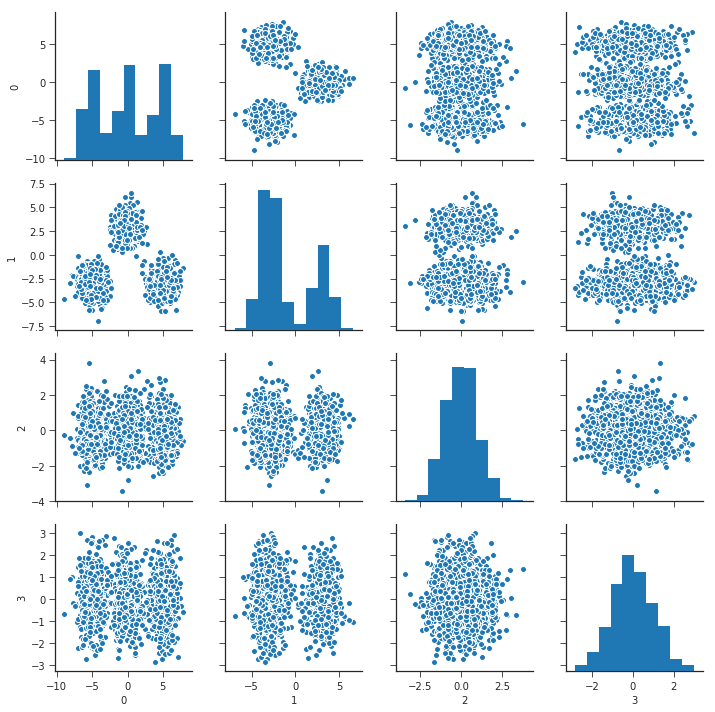

In [10]:
sns.pairplot(pd.DataFrame(X))

In [11]:
mi = np.zeros([4, 4])
cmi = np.zeros([4, 4])
for i, j in tqdm.tqdm([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]):
    mi[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200, maxiter=100000)
    mask = (np.arange(4) != i) & (np.arange(4) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], n_b=200, maxiter=100000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=100000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=100000)
    cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 6/6 [01:50<00:00, 17.60s/it]


array([[ 0.        ,  0.58376465, -0.00280244, -0.00116771],
       [ 0.        ,  0.        , -0.01443977, -0.00199111],
       [ 0.        ,  0.        ,  0.        , -0.00497238],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [12]:
model = sklearn.covariance.GraphLasso(alpha=0.3)
model.fit(X)

GraphLasso(alpha=0.3, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

In [14]:
cov = np.cov(X.transpose())

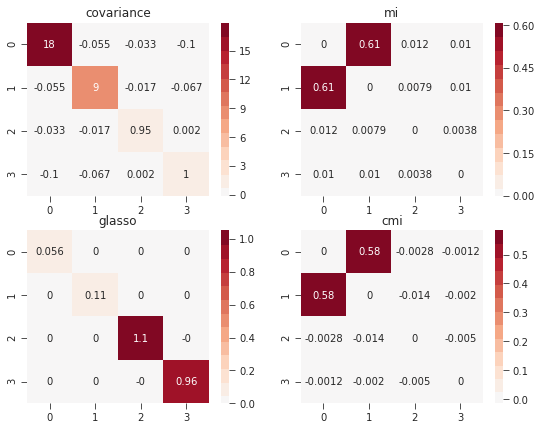

In [15]:
f, axes = plt.subplots(2, 2, figsize=[9, 7])
axes[0, 0].set_title('covariance')
axes[0, 1].set_title('mi')
axes[1, 0].set_title('glasso')
axes[1, 1].set_title('cmi')
sns.heatmap(cov, annot=True, ax=axes[0, 0], center=0, cmap=palette)
sns.heatmap(mi + np.transpose(mi), annot=True, ax=axes[0, 1], center=0, cmap=palette)
sns.heatmap(model.precision_, annot=True, ax=axes[1, 0], center=0, cmap=palette)
sns.heatmap(cmi + np.transpose(cmi), annot=True, ax=axes[1, 1], center=0, cmap=palette)
plt.savefig('cmi2.png', dpi=120)